# Teeth Segmentation Using U-Net

In [2]:
!git clone https://github.com/mymni/teeth-xray-detect.git

Cloning into 'teeth-xray-detect'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 8.10 MiB | 15.79 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append("/content/teeth-xray-detect")
%cd /content/teeth-xray-detect

/content/teeth-xray-detect


## Downloading Dataset

In [5]:
import requests
from zipfile import ZipFile
from io import BytesIO
import os

def download_dataset(save_path):
    r = requests.get("https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxt48yk462-1.zip")
    print("Downloading...")
    z = ZipFile(BytesIO(r.content))
    z.extractall(save_path)
    print("Completed...")

path = "/content/Data"
if os.path.exists(path+'/DentalPanoramicXrays.zip') == False:
  download_dataset(path+'/')

Downloading...
Completed...


## Preparing Images + Mask

In [6]:
import numpy as np
from PIL import Image
from natsort import natsorted

def convert_one_channel(img):
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

def pre_images(resize_shape,path,include_zip):
    if include_zip==True:
        ZipFile(path+"/DentalPanoramicXrays.zip").extractall(path)
        path=path+'/Images/'
    dirs=natsorted(os.listdir(path))
    sizes=np.zeros([len(dirs),2])
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images=convert_one_channel(np.asarray(images))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return images,sizes

X,X_sizes=pre_images((512,512),path,True)

<ipython-input-6-b6d25b0897b4>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  images=(images.resize((resize_shape),Image.ANTIALIAS))
<ipython-input-6-b6d25b0897b4>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img=img.resize((resize_shape),Image.ANTIALIAS)


In [8]:
import sys
script_dir=os.path.abspath(os.path.dirname(sys.argv[0]))
default_path=script_dir+'/Original_Masks/'

def convert_one_channel(img):
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

def pre_masks(resize_shape=(512,512),path=default_path):
    ZipFile(path+"/Orig_Masks.zip").extractall(path+'/Masks/')
    path=path+'/Masks/'
    dirs=natsorted(os.listdir(path))
    masks=img=Image.open(path+dirs[0])
    masks=(masks.resize((resize_shape),Image.ANTIALIAS))
    masks=convert_one_channel(np.asarray(masks))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        masks=np.concatenate((masks,img))
    masks=np.reshape(masks,(len(dirs),resize_shape[0],resize_shape[1],1))
    return masks

default_path=script_dir+'/Custom_Masks/'

def pre_splitted_masks(path=default_path):
    ZipFile(path+"/splitted_masks.zip").extractall(path+'/Masks/')
    path=path+'/Masks/'
    dirs=natsorted(os.listdir(path))
    masks=img=Image.open(path+dirs[0])
    masks=convert_one_channel(np.asarray(masks))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        img=convert_one_channel(np.asarray(img))
        masks=np.concatenate((masks,img))
    masks=np.reshape(masks,(len(dirs),512,512,1))
    return masks

Y=pre_splitted_masks(path='/content/teeth-xray-detect/Custom_Masks')

In [9]:
X=np.float32(X/255)
Y=np.float32(Y/255)

In [10]:
x_train=X[:105,:,:,:]
y_train=Y[:105,:,:,:]
x_test=X[105:,:,:,:]
y_test=Y[105:,:,:,:]

## Data Augmentation

In [11]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-hka2d31i
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-hka2d31i
  Resolved https://github.com/albu/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


In [12]:
import cv2
import albumentations as A

aug = A.Compose([
    A.OneOf([A.RandomCrop(width=512, height=512),
                 A.PadIfNeeded(min_height=512, min_width=512, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
                            A.Resize(512, 512, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)
count=0
while(count<4):
  x_aug2=np.copy(x_train1)
  y_aug2=np.copy(y_train1)
  for i in range(len(x_train1)):
    augmented=aug(image=x_train1[i,:,:,:],mask=y_train1[i,:,:,:])
    x_aug2[i,:,:,:]= augmented['image']
    y_aug2[i,:,:,:]= augmented['mask']
  x_train=np.concatenate((x_train,x_aug2))
  y_train=np.concatenate((y_train,y_aug2))
  if count == 9:
    break
  count += 1

del x_aug2, X, Y, y_aug2, y_train1, x_train1, augmented

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


100


(Text(0.5, 1.0, 'Training Mask'), ([], []), ([], []))

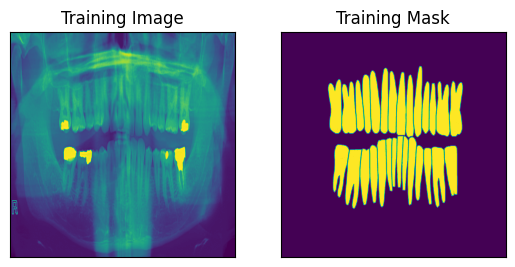

In [14]:
#picture + mask
import random
import matplotlib.pyplot as plt
ind = random.randint(0, 105)
print(ind)
plt.subplot(121), plt.imshow(x_train[ind,:,:,0])
plt.title('Training Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(y_train[ind,:,:,0])
plt.title('Training Mask'), plt.xticks([]), plt.yticks([])

## U-Net Architecture

In [15]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/dental_xray_seg.keras')

### we could load the model from our saved drive since the training takes some time ###
### this is what we did to get it:
from model import *
model=UNET(input_shape=(512,512,1),last_activation='sigmoid')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         320       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['dropout[0][0]']             
                                                                                              

## Model Training

In [16]:
### comment below if already loaded (since the training takes some time), here's how we trained it ###
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x_train,y_train,batch_size=8,epochs=25,verbose=1)
# tf.keras.models.save_model(model, '/content/drive/MyDrive/dental_xray_seg.keras')

Epoch 1/25
66/66 [==============================] - 158s 2s/step - loss: 0.4003 - accuracy: 0.7766
Epoch 2/25
66/66 [==============================] - 81s 1s/step - loss: 0.2864 - accuracy: 0.8268
Epoch 3/25
66/66 [==============================] - 81s 1s/step - loss: 0.2221 - accuracy: 0.8575
Epoch 4/25
66/66 [==============================] - 80s 1s/step - loss: 0.2000 - accuracy: 0.8665
Epoch 5/25
66/66 [==============================] - 81s 1s/step - loss: 0.1896 - accuracy: 0.8711
Epoch 6/25
66/66 [==============================] - 81s 1s/step - loss: 0.1811 - accuracy: 0.8742
Epoch 7/25
66/66 [==============================] - 80s 1s/step - loss: 0.1688 - accuracy: 0.8785
Epoch 8/25
66/66 [==============================] - 80s 1s/step - loss: 0.1682 - accuracy: 0.8798
Epoch 9/25
66/66 [==============================] - 80s 1s/step - loss: 0.1589 - accuracy: 0.8839
Epoch 10/25
66/66 [==============================] - 81s 1s/step - loss: 0.1527 - accuracy: 0.8860
Epoch 11/25
66/66 

## Predictions

In [17]:
# generate predictions
predict_img=model.predict(x_test)

1/1 [==============================] - 16s 16s/step


Evaluation

In [18]:
from sklearn.metrics import f1_score
import numpy as np
predict_img1=(predict_img>0.4)*1
y_test1=(y_test>0.4)*1

f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9513033086603339

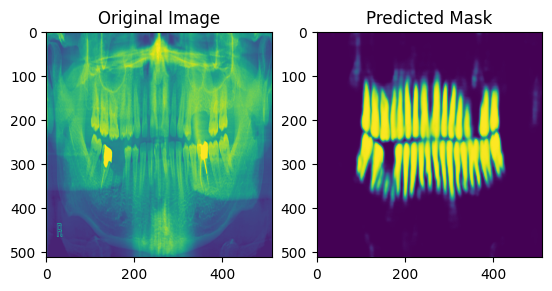

In [19]:
plt.subplot(1, 2, 1)
plt.title("Original Image")
original = x_test[1, :, :, 0]
plt.imshow(original)
plt.imsave("/content/original.png", original)

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
predict = predict_img[1, :, :, 0]
plt.imshow(predict)
plt.imsave("/content/predict.png", predict)

## Postprocessing and generating masks + detection

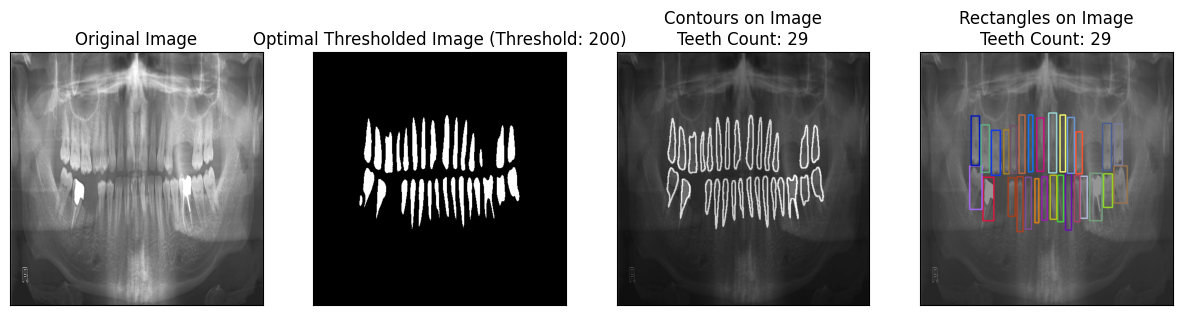

Optimal Threshold: 200
Number of Teeth: 29


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

background = cv2.imread('/content/original.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('/content/predict.png', cv2.IMREAD_GRAYSCALE)

# Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Laplacian sharpening
sharpened = cv2.addWeighted(blurred, 1.5, image, -0.5, 0)

optimal_threshold = 0
max_teeth_count = 0

for threshold_value in range(150, 255, 1):
    _, thresholded = cv2.threshold(sharpened, threshold_value, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(thresholded, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_contour_area = 200
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    teeth_count = len(contours)

    if teeth_count > max_teeth_count:
        max_teeth_count = teeth_count
        optimal_threshold = threshold_value

_, optimal_thresholded = cv2.threshold(sharpened, optimal_threshold, 255, cv2.THRESH_BINARY)

# morphological operations (dilation and erosion) to the optimal thresholded image
kernel = np.ones((3, 3), np.uint8)
optimal_dilated = cv2.dilate(optimal_thresholded, kernel, iterations=1)
optimal_eroded = cv2.erode(optimal_dilated, kernel, iterations=1)

# contours with external retrieval mode on the optimal thresholded image
optimal_contours, _ = cv2.findContours(optimal_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# filter contours based on area
optimal_contours = [cnt for cnt in optimal_contours if cv2.contourArea(cnt) > min_contour_area]

contour_image = np.zeros_like(background)
cv2.drawContours(contour_image, optimal_contours, -1, (255, 255, 255), 2)
output_image = cv2.addWeighted(background, 0.5, contour_image, 0.5, 0)

rectangle_image = np.stack([background, background, background], axis=-1)
rectangle_image = cv2.addWeighted(rectangle_image, 0.3, rectangle_image, 0.4, 0)

for i, cnt in enumerate(optimal_contours):
    x, y, w, h = cv2.boundingRect(cnt)
    center_x, center_y = x + w // 2, y + h // 2

    # expand the rectangle by 1.1 times its original size relative to its center (in case it didn't fit the tooth)
    new_w = int(w * 1.1)
    new_h = int(h * 1.1)
    x = max(0, center_x - new_w // 2)
    y = max(0, center_y - new_h // 2)

    # different color for each rectangle
    color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
    cv2.rectangle(rectangle_image, (x, y), (x + new_w, y + new_h), color, 2)

plt.figure(figsize=(15, 5))

plt.subplot(141), plt.imshow(background, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(142), plt.imshow(optimal_thresholded, cmap='gray')
plt.title(f'Optimal Thresholded Image (Threshold: {optimal_threshold})'), plt.xticks([]), plt.yticks([])

plt.subplot(143), plt.imshow(output_image, cmap='gray')
plt.title(f'Contours on Image\nTeeth Count: {max_teeth_count}'), plt.xticks([]), plt.yticks([])

plt.subplot(144), plt.imshow(rectangle_image)
plt.title(f'Rectangles on Image\nTeeth Count: {max_teeth_count}'), plt.xticks([]), plt.yticks([])
plt.show()

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Number of Teeth: {max_teeth_count}")

In [22]:
#tf.keras.models.save_model(model, '/content/drive/MyDrive/dental_xray_seg.keras')